# Kernel OMP
By Martin de Quincey, March 2022.

In [1]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt

### Auxilliary functions
- $\texttt{Lamda_to_adj}:$ Convert an adjacency list $\texttt{Lambda}$ to an adjacency matrix $\texttt{adj_mat}$. We do this simply by setting all elements that appear in lambda to one per column.
- $\texttt{is_dag}$: Verifyies whether a weighted adjacency matrix $\texttt{W_in}$ is a directed acyclic graph (self-loops allowed). We do this by iteratively removing the column and row that contain only zeros. If no such row and column exists, the adjacency matrix does not correspond to a directed acyclic graph.

In [2]:
def Lambda_to_adj(Lambda):
    """Convert Lambda list to adjacency matrix"""
    
    # p, number of variables
    p = len(Lambda)
    adj_mat = np.zeros((p, p))

    # set all elements that appear in lambda to 1
    for i, col in enumerate(Lambda):
        adj_mat[i, col] = 1 

    # return the adjacency matrix
    return adj_mat

def is_dag(W_in):
    """Verifies whether an adjacency matrix corresponds to a directed acyclic graph"""
    
    # get dimension
    p = np.shape(W_in)[0]

    # copy to modify it
    W = W_in.copy()

    # remove diagonal entries, as self-loops are allowed
    np.fill_diagonal(W, 0)

    # save the current order and old ordering
    order, old_order = [], list(range(p))

    # for the number of elements
    for i in range(p):
        # find a row that contains only zeros
        for j in range(p - i):
            # if we find a zero row (excl. diags)
            if not W[j].any() != 0:
                # remove this row and column
                W = np.delete(W, j, 0)
                W = np.delete(W, j, 1)

                # append this to our known order
                order.append(old_order[j])
                old_order.remove(old_order[j])

                # go to next variable
                break

            # if no zero row exist stop
            elif i == p - 1:
                # we do not have a directed acyclic graph
                return False
            
    # we have a directed acyclic graph with an order
    return True, order

### Kernel OMP
Parameters: $X$, $Y$. 
Goal: Find coefficient matrix $W$ such that $Y = XW$, where $W$ is as sparse as possible.

If $\mathbf{X}$ is data from a VAR(1) model, then $X = \mathbf{X}_{-T}$, $Y = \mathbf{X}_{-1}$, so $X$ has the last entry removed, and $Y$ has the first entry removed.

If $\mathbf{X}$ is data from a SEM model, then $X = \mathbf{X}$, $Y = \mathbf{X}$, but we cannot estimate the diagonal of $W$, because then $W = I$ would be a trivial solution.

Stopping criteria:
- max_coefs: maximum number of non-zero coefficients. stop when this value is exceeded.
- tol_gain: maximum of gains. stop when all gains are below this tolerance.
- tol_res: maximum of residual. stop when the residual is below this tolerance.

Extra:
- verbose: prints steps at each itersion, only useful for < 10 variables.
- is_sem: flag that allows us to choose between two models, VAR(1) and SEM. If SEM, we are not allowed to use diagonals.

Inner workings (l.38 - l.97):
1. (l.39 - l.45) We iteratively find the next coefficient that yields the largest gain of all possible candidates. 
2. (l.47 - l.50) If the largest gain is not good enough, we stop according to our stopping criterion.
3. (l.42 - l.55) Else, we add this to our support.
4. (l.57 - l.72) We check if adding this edge does not create a directed acyclic graph. If it is still a DAG, we re-estimate the coefficients using ordinary least squares restricted to the support.
5. (l.74 - l.80)If adding the edge creates a cycle, then we need to remove this edge, and we add it to the forbidden set.
6. (l.82 - l.97) We check for two of the three aforementioned stopping criteria, and print iteration info if requested.

In [3]:
def kernel_OMP(X, Y, max_coefs = 1e10, tol_gain = 0.0, tol_res = 0.0, verbose = False, is_sem = False):
    """
    Perform Kernel OMP, using X as endogenuous and Y as exogenous variables.
    @params:  X:         Feature matrix X, consisting of T samples of p variables.
              Y:         Response matrix Y, consisting of T samples of p variables.
              max_coefs: Maximum number of coefficients that we will estimate before terminating.
              tol_gain:  Stopping Criterion. If all non-zero coefficients have gain below tol_gain, we stop.
              tol_res:   Stopping Criterion. If the current solution W achieves a squared residual error below tol_res, we stop.
              verbose:   Flag on whether we want output at every iteration, or just the final solution.
              is_sem:    Flag whether we are focusing on a structural equations model, or a vector autoregressive model of order (1).
    @returns: W:         A p x p dimensional matrix such that G(W) is a directed acyclic graph.
                         Furthermore, it aims to minimize ||Y - XW||_F^2 using as few coefficients as possible.
              Ws:        A list of p x p dimensional matrices, each representing the kernel_OMP solution at iteration i.
    """

    # get dimensions of data matrix X
    T, p = np.shape(X)
    
    # initialize W (matrix to return), Ws (list of iterations of W).
    W, Ws = np.zeros((p, p)), []
    
    # initialize Lambda (adjacency list of W), and F (list of forbidden edges).
    Lambda, F, idx = [[] for _ in range(p)], [], []
    
    # in a sem, diagonals must be zero, so we add diagonals to forbidden set
    if is_sem:
        F = [i * (p + 1) for i in range(p)]

    # compute kernel spaces, save inner products for fast computation time of multiple OLS solutions
    Psi = X.T.dot(X)                    # p times p
    K = X.T.dot(Y)                      # p times p
    Theta = [y.T.dot(y) for y in Y.T]   # p times 1

    # compute norms for normalization
    norms = [np.linalg.norm(x, 2) for x in X.T]

    # for each possible coefficient, maximum p^2.
    for i in range(p ** 2):    
        # compute gains
        gains = np.abs([(k - W.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        
        # set forbidden set to -1, so that we can never pick them
        gains = gains.flatten()
        gains[F] = -np.ones(len(F))
        gains = gains.reshape(p, p)
        
        # stopping criterion 1, tolerance on gain
        if gains.max() <= tol_gain: 
            print(f"All gains are smaller than {tol_gain}. Terminate.")
            break

        # append best atom to Lambda
        idx_max = np.argmax(gains)
        row, col = idx_max // p, idx_max % p
        Lambda[col].append(row)
        
        # check if we have a DAG
        if is_dag(Lambda_to_adj(Lambda)): 
            
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]

            # speedup: add transpose to forbidden set
            F.append(idx_max)
            F.append(col * p + row)

            # update W, perform OLS on
            W[np.array(idx)[:, None], col] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], col]

            # keep track of order of edges added
            Ws.append(W.copy())

        # if adding the edge violates dagness
        else: 
            # append forbidden entry to forbidden list
            F.append(int(idx_max))
            
            # remove coefficient from Lambda
            Lambda[col].remove(row)

        # stopping criterion 2, compute two norm of the residual
        if sum([Theta[i] - K[:, i] @ W[:, i] for i in range(p)]) < tol_res:
            print(f"Residual Squared of {tol_res} reached. Terminate.")
            break
            
        # stopping criterion 3, max number of coefficients
        elif len(np.nonzero(W)[0]) >= max_coefs: 
            print(f"Maximum number of edges reached: {max_coefs}. Terminate.")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(W, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ W[:, i] for i in range(p)], 3)}.\n\n")
    
    # we have broken the for loop, so we have a dense DAG, or have reached a stopping criterion
    return W, Ws

### Example

In [4]:
def generate_var(T, p, W):
    """Generates a VAR(1) model with coefficient matrix W.
        
        @params   T: Number of time steps
                  p: number of variables
                  W: coefficient matrix
        @returns  X: T x p data matrix such that X_{t+1} = X_t W + noise according to a VAR(1) model.
    """
    
    # Initialize series
    X = np.array(np.zeros((T, p)))
    noises = np.random.multivariate_normal(np.zeros(p), np.identity(p), T)
    
    # Generate series
    for t in range(1, T):
        X[t] = X[t - 1] @ W + noises[t]
    
    # Return series
    return X

def generate_sem(n, p, W):
    """Generates a SEM model with coefficient matrix W.
        
        @params   n: Number of time steps
                  p: number of variables
                  W: coefficient matrix, such that G(W) is a directed acyclic graph.
        @returns  X: n x p data matrix such that X = X W + noise.
    """
    
    # Initialize series
    X = np.array(np.zeros((n, p)))
    noises = np.random.multivariate_normal(np.zeros(p), 0.01 * np.identity(p), n)
    
    # Generate series
    for k in range(n):
        for i in range(1, p + 1):
            X[k, -i] = X[k] @ W[:, -i] + noises[k, -i]
    
    # Return series
    return X

def generate_W(p, s, diag = True, low = 0.30, high = 0.95):
    """Generates a coefficient matrix W such that G(W) is a directed acyclic graph with self-loops
       @params:  p: number of variables
                 s: number of off-diagonal non-zero elements
                 diag: whether or not to fill the diagonal with non-zero elements
                 low: lower bound on the non-zero coefficient value
                 high: upper bound on the non-zero coefficient value
       @returns: W: a coefficient matrix W such that $G(W)$ is a directed acyclic graph. 
                    contains p * diag + s edges, of which p * diag are on the diagonal (self-loops)
    """
    
    # Initialize series
    W = np.zeros((p, p))
    
    # randomly generate s edges
    edges = np.array([0.0] * (int(p * (p - 1) / 2) - s) + [1.0] * s)
    np.random.shuffle(edges)
    
    # randomly generate edges in -(high, low) \cup (low, high)
    edges[edges > 0] = (2 * np.random.randint(0, 2, s) - 1) * np.random.uniform(low, high, s)
    W[np.tril_indices(p, -1)] = edges
    
    # since var, we set diagonals to a positive weight
    if diag:
        for i in range(p):
            W[i][i] = np.random.uniform(low, high)
    
    return W

#### Example 1, Simple four dimensional graph.

W:
[[ 0.6  0.   0.   0. ]
 [ 0.   0.6  0.   0. ]
 [ 0.6  0.9  0.5  0. ]
 [ 0.   0.  -0.7  0.8]].

All gains are smaller than 2.5. Terminate.
W_OMP:
[[ 0.6  0.   0.   0. ]
 [ 0.   0.6  0.   0. ]
 [ 0.6  0.9  0.5  0. ]
 [ 0.   0.  -0.8  0.8]].


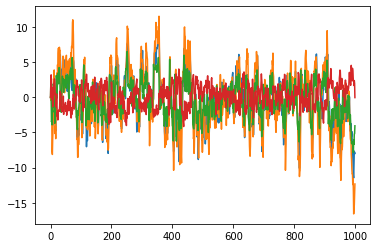

In [5]:
np.random.seed(seed = 123)

# generate VAR(1)
T, p, s = 1000, 4, 3
W = generate_W(p, s)
X = generate_var(T, p, W)
plt.plot(X)
print(f"W:\n{np.round(W, 1)}.\n")

# perform kernel_OMP as VAR
W_OMP, Ws = kernel_OMP(X[:-1], X[1:], verbose = False, tol_gain = 2.5)
print(f"W_OMP:\n{np.round(W_OMP, 1)}.")

#### Example 2, Simple four-dimensional SEM

In [6]:
# generate SEM
np.random.seed(seed = 123)

n, p, s = 1000, 4, 4
W = generate_W(p, s, diag = False)
X = generate_sem(n, p, W)
print(f"W:\n{np.round(W, 1)}.\n")

# perform kernel_OMP as VAR
W_OMP, Ws = kernel_OMP(X, X, is_sem = True, tol_gain = 0.25)
print(f"W_OMP:\n{np.round(W_OMP, 3)}.")

W:
[[ 0.   0.   0.   0. ]
 [ 0.   0.   0.   0. ]
 [ 0.8  0.6  0.   0. ]
 [ 0.  -0.7  0.4  0. ]].

All gains are smaller than 0.25. Terminate.
W_OMP:
[[ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.806  0.558  0.     0.   ]
 [ 0.    -0.631  0.371  0.   ]].
